In [3]:
import numpy as np
import pandas as pd
import math
from pandas.api.types import CategoricalDtype
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import scipy
from hmmlearn import hmm
import plotly.express as px
import random

from scipy.stats import norm as normal
from scipy.stats import multivariate_normal as mvn
from sklearn.mixture import GaussianMixture as GMM
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid", 
color_codes = True,
font_scale = 1.5)

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel, ExpSineSquared, DotProduct, Matern, RationalQuadratic

In [4]:
kernel1 = ConstantKernel(constant_value_bounds=(1e-2, 10000000)) 
kernel2 = RBF(length_scale=1.5, length_scale_bounds=(1e-3, 1e5))     
kernel3 = WhiteKernel(noise_level=.1, noise_level_bounds=(1e-10, 1e6))
kernel4 = DotProduct()
kernel5 = ExpSineSquared()
kernel6 = Matern()
kernel7 = RationalQuadratic()
ARDkernel = 1.0 * RBF(length_scale=2*np.ones(4), length_scale_bounds=(1e-3, 1e10))

kernel_names = ['Constant','RBF', 'WhiteNoise', 'DotProduct', 'ExpSineSquared', 'Matern','RationalQuadratic']
kernel_list = [kernel1,
              kernel2,
              kernel3,
              kernel4,
              kernel5,
              kernel6,
              kernel7]

---
### Pre-Process DATA 
---

In [5]:
training_data = pd.read_csv("train_set.csv")
test_data = pd.read_csv("test_set.csv")

In [6]:
'''Data dropping NaN values'''
Xtrain_NaN = training_data.dropna()
Ytrain_NaN = Xtrain_NaN[['target']]
Xtrain_NaN = Xtrain_NaN.drop(['ID', 'target'], axis=1)
Xtrain_NaN.shape

(671, 30)

In [7]:
'''Original datasets for model processing'''
Xtrain = training_data.drop(['ID', 'target'], axis=1)
Ytrain = training_data[['target']]
Xtest = test_data.drop('ID', axis=1)

In [8]:
''' Here we impute the missing values of the Data '''
imputer = SimpleImputer(strategy='mean')  # Change 'mean' to 'median' or 'most_frequent'
Xtrain_imputed = imputer.fit_transform(Xtrain)
Xtrain_imputed = pd.DataFrame(Xtrain_imputed, columns=Xtrain.columns)

In [9]:
''' Here we impute the missing values of the Data with a different strategy'''
imp_mean = IterativeImputer(random_state=42)
imp_mean.fit(Xtrain)
Xtrain_iterimp = pd.DataFrame(imp_mean.transform(Xtrain), columns=Xtrain.columns)

In [10]:
''' Scale the set of Data that will be used'''
alpha_scaler = StandardScaler()
alpha_scaler.fit(Xtrain_iterimp) 
X_scaled_ = pd.DataFrame(alpha_scaler.transform(Xtrain_iterimp), columns=Xtrain.columns)

---
### Process to prune co-linear variables 
---

In [11]:
'''Procedure I used to clean data and get rid off colinear variables'''

coeff_matrix = X_scaled_.corr()
filtered_corr = coeff_matrix.where((coeff_matrix > 0.75) | (coeff_matrix < -0.75), 0)
strong_corr_features = filtered_corr.columns[filtered_corr.notna().any()].tolist()
strong_corr_pairs = filtered_corr.unstack().dropna()

# Remove self-correlations by keeping only unique pairs (each pair appears twice in a symmetric matrix)
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs.index.get_level_values(0) != strong_corr_pairs.index.get_level_values(1)]

# Remove duplicate pairs (since (A, B) and (B, A) are the same in correlation)
strong_corr_pairs = strong_corr_pairs[~strong_corr_pairs.index.duplicated()]

# Convert to a DataFrame for easier viewing
strong_corr_pairs_df = pd.DataFrame(strong_corr_pairs, columns=['Correlation']).reset_index()
strong_corr_pairs_df.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Display the result
corr_df = strong_corr_pairs_df[strong_corr_pairs_df['Correlation']!= 0]
display(corr_df)
corr_df["Ordered Pair"] = corr_df.apply(lambda row: tuple(sorted([row["Feature 1"], row["Feature 2"]])), axis=1)
unique_pairs = corr_df.drop_duplicates(subset="Ordered Pair")
unique_pairs.drop("Ordered Pair", axis=1)

,Feature 1,Feature 2,Correlation
36,feat_1,feat_8,-0.930397
190,feat_6,feat_17,-0.829957
233,feat_8,feat_1,-0.930397
484,feat_16,feat_21,-0.995159
499,feat_17,feat_6,-0.829957
601,feat_20,feat_22,-0.967206
625,feat_21,feat_16,-0.995159
658,feat_22,feat_20,-0.967206


,Feature 1,Feature 2,Correlation
36,feat_1,feat_8,-0.930397
190,feat_6,feat_17,-0.829957
484,feat_16,feat_21,-0.995159
601,feat_20,feat_22,-0.967206


In [12]:
coeff_matrix['feat_22'].drop(['feat_6', 'feat_22']).abs().sum()
#Xtrain_cleaned = X_scaled_.drop(['feat_1', 'feat_17',
                            #'feat_16', 'feat_22'], axis=1)

## for redo: 1,6, 16, 22

5.594764841505406

In [13]:
Xtrain_cleaned = X_scaled_.drop(['feat_1', 'feat_17',
                            'feat_21', 'feat_22'], axis=1)

In [14]:
coeff_matrix = Xtrain_cleaned.corr()
filtered_corr = coeff_matrix.where((coeff_matrix > 0.75) | (coeff_matrix < -0.75), 0)
strong_corr_features = filtered_corr.columns[filtered_corr.notna().any()].tolist()
strong_corr_pairs = filtered_corr.unstack().dropna()

# Remove self-correlations by keeping only unique pairs (each pair appears twice in a symmetric matrix)
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs.index.get_level_values(0) != strong_corr_pairs.index.get_level_values(1)]

# Remove duplicate pairs (since (A, B) and (B, A) are the same in correlation)
strong_corr_pairs = strong_corr_pairs[~strong_corr_pairs.index.duplicated()]

# Convert to a DataFrame for easier viewing
strong_corr_pairs_df = pd.DataFrame(strong_corr_pairs, columns=['Correlation']).reset_index()
strong_corr_pairs_df.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Display the result
corr_df = strong_corr_pairs_df[strong_corr_pairs_df['Correlation']!= 0]
corr_df

,Feature 1,Feature 2,Correlation


---
### Functions and other miscallenous things 
---

In [15]:
def bic_val(data, K_list):
    bic_scores=[]
    for k in K_list:
        gmm = GMM(n_components=k, covariance_type='diag', random_state=42)
        gmm.fit(data)
        bic_scores.append(gmm.bic(data))

    plt.figure(figsize=(10, 6))
    plt.plot(K_list, bic_scores, marker='o')
    plt.title('BIC Curve for Gaussian Mixture Models', fontsize=16)
    plt.xlabel('Number of Components (K)', fontsize=14)
    plt.ylabel('Bayesian Information Criterion (BIC)', fontsize=14)
    plt.xticks(K_list)
    plt.grid(True)
    plt.show()

    optimal_K = K_list[np.argmin(bic_scores)]
    
    return optimal_K

In [16]:
''' 
Procedure to pull inliers from a matrix. Accuracy score is based on SVC with gamma=0.01, C=100.
This can be adjusted in function. 
'''

def inspect_inliers(X, Y, gamma=0.01, C=100):
    for nu_val in [ 0.001, 0.002, 0.005, 0.007,  0.008, 0.009, 0.01, 0.1, 0.2, 0.3]:
        '''
        First we scale the values in the new data set and then pass it onto the OCSVM. We then extract the values that have been detected
        as inliers and concatenate the inliers with the initial data set.

        ('scaler', StandardScaler()),
        '''
        pipe_oc = Pipeline([('ocsvm', OneClassSVM(kernel="rbf", gamma='scale', nu=nu_val))])
        ocsvm_inliers = pipe_oc.fit_predict(X)
        Xinliers = X[ocsvm_inliers==1]
        Yinliers = Y[ocsvm_inliers==1]
    
        print("Percentage of inliers in initial data: {}".format(np.sum([ocsvm_inliers==1])/len(ocsvm_inliers)))
                                                                                             
        print("nu_val is: {}. There are {} inliers in X.".format(nu_val,len(Xinliers))) 
    
        
        pipe_inliers = Pipeline([('svc', SVC(kernel="rbf", gamma=gamma, C=C))])
        score_value = pipe_inliers.fit(Xinliers, Yinliers).score(X, Y)
        print("Accuracy score for inliers on the initial dataset is {}.".format(score_value))
        print()

In [17]:
def get_inliers(X,Y, nu=0.007):
    pipe_oc = Pipeline([('scaler', StandardScaler()), ('ocsvm', OneClassSVM(kernel="rbf", gamma='scale', nu=0.007))])
    ocsvm_inliers = pipe_oc.fit_predict(X, Y)
    Xinliers = X[ocsvm_inliers==1]
    Yinliers = Y[ocsvm_inliers==1]
    return Xinliers, Yinliers

In [18]:
'''
Useful pipeline
'''
def thresholded_accuracy(y_true, y_pred, threshold=0.5):
        y_pred_binary = (y_pred >= threshold).astype(int)
        return accuracy_score(y_true, y_pred_binary)
    
#A scorer that applies thresholded accuracy
thresholded_accuracy_scorer = make_scorer(thresholded_accuracy, greater_is_better=True)

def run_pipeline(X,Y, kernel):
    param_grid = {
        "kernel": [kernel],
        "alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}
    
    # Initialize GridSearchCV scorer
    grid_search = GridSearchCV(
        GaussianProcessRegressor(),
        param_grid,
        cv=5,
        scoring=thresholded_accuracy_scorer,
        n_jobs=-1)
    
    # Fit the model to the data
    grid_search.fit(X, Y)
    
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)

---
### Data Cleaning 
---

In [19]:
'''
Random Forest using Xtrain_clean *CAREFUL bc MANY VARIABLES SHARE THE SAME NAME*
i.e. got rid of colinear features and then extra cleaning with random forest
'''
clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=50, random_state=42)

random_forest = clf.fit(Xtrain_cleaned, Ytrain)
accuracy = random_forest.score(Xtrain_cleaned, Ytrain)
print("Accuracy of RF is: {}".format(accuracy))

relevance = random_forest.feature_importances_  

feature_names = Xtrain_cleaned.columns

# Create a DataFrame to store feature importances with names
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': relevance
})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df


Accuracy of RF is: 0.995


,Feature,Importance
5,feat_6,0.180065
14,feat_15,0.118756
18,feat_20,0.074970
3,feat_4,0.068330
13,feat_14,0.062550
24,feat_28,0.060034
6,feat_7,0.056860
9,feat_10,0.056223
22,feat_26,0.040238
23,feat_27,0.034652


In [2941]:
features_to_keep = feature_importances_df[feature_importances_df['Importance'] >= 0.012]['Feature']

features_to_keep
Xcleaned_reduced = Xtrain_cleaned[np.array(features_to_keep)]
print(Xcleaned_reduced.shape)
print(Xtrain_cleaned.shape)

(1000, 22)
(1000, 26)


In [2942]:
reduced_model = clf.fit(Xcleaned_reduced, Ytrain)
reduced_accuracy = reduced_model.score(Xcleaned_reduced, Ytrain)

print("Accuracy with reduced features:", reduced_accuracy)

relevance = reduced_model.feature_importances_  

feature_names = Xcleaned_reduced.columns

# Create a DataFrame to store feature importances with names
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': relevance
})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df

Accuracy with reduced features: 0.992


,Feature,Importance
0,feat_6,0.145512
1,feat_15,0.125146
2,feat_20,0.093740
5,feat_14,0.077788
7,feat_10,0.077468
4,feat_28,0.075189
3,feat_4,0.065531
6,feat_7,0.044168
8,feat_26,0.038799
9,feat_27,0.035927


In [2943]:
pipe = Pipeline([('svc', SVC())])
param_grid_gamma = {'svc__gamma': [0.001, 0.01, 0.02, 0.03, 0.04, 0.1, 1, 2], 
                     'svc__C': [0.1, 1, 10, 100, 1000], 
                     'svc__kernel':['rbf']} 
nonlin_grid = GridSearchCV(estimator=pipe,
                            param_grid=param_grid_gamma,
                            cv=5, n_jobs=-1)
nonlin_grid.fit(Xcleaned_reduced, Ytrain.values.flatten())
print(nonlin_grid.best_params_)
print(nonlin_grid.best_score_)
print(nonlin_grid.best_estimator_)

{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
0.893
Pipeline(steps=[('svc', SVC(C=1, gamma=0.1))])


In [2944]:
inspect_inliers(Xcleaned_reduced, Ytrain, 0.1, 1)

Percentage of inliers in initial data: 0.956
nu_val is: 0.001. There are 956 inliers in X.
Accuracy score for inliers on the initial dataset is 0.985.

Percentage of inliers in initial data: 0.958
nu_val is: 0.002. There are 958 inliers in X.
Accuracy score for inliers on the initial dataset is 0.982.

Percentage of inliers in initial data: 0.95
nu_val is: 0.005. There are 950 inliers in X.
Accuracy score for inliers on the initial dataset is 0.982.

Percentage of inliers in initial data: 0.953
nu_val is: 0.007. There are 953 inliers in X.
Accuracy score for inliers on the initial dataset is 0.98.

Percentage of inliers in initial data: 0.954
nu_val is: 0.008. There are 954 inliers in X.
Accuracy score for inliers on the initial dataset is 0.98.

Percentage of inliers in initial data: 0.955
nu_val is: 0.009. There are 955 inliers in X.
Accuracy score for inliers on the initial dataset is 0.984.

Percentage of inliers in initial data: 0.954
nu_val is: 0.01. There are 954 inliers in X.
A

In [2945]:
Xinliers_cleaned_red, Yinliers_cleaned_red = get_inliers(Xcleaned_reduced, Ytrain, 0.002)

In [2946]:
random_forest = clf.fit(Xinliers_cleaned_red, Yinliers_cleaned_red)
accuracy = random_forest.score(Xinliers_cleaned_red, Yinliers_cleaned_red)
print("Accuracy of RF is: {}".format(accuracy))

relevance = random_forest.feature_importances_  

feature_names = Xinliers_cleaned_red.columns

# Create a DataFrame to store feature importances with names
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': relevance
})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df

Accuracy of RF is: 0.9947534102833159


,Feature,Importance
0,feat_6,0.134937
1,feat_15,0.124810
2,feat_20,0.090395
4,feat_28,0.081334
7,feat_10,0.077985
5,feat_14,0.075334
3,feat_4,0.063157
6,feat_7,0.047933
9,feat_27,0.043110
8,feat_26,0.034413


In [2947]:
features_to_keep = feature_importances_df[feature_importances_df['Importance'] >= 0.02]['Feature']

features_to_keep
Xcleaned_reduced2 = Xinliers_cleaned_red[np.array(features_to_keep)]
print(Xcleaned_reduced2.shape)
print(Xinliers_cleaned_red.shape)

(953, 15)
(953, 22)


---
### Formal Approach
---

In [540]:
pca_ = PCA(n_components=2, random_state=42)
pca_.fit(Xtrain_cleaned)
X_reduced = pca_.transform(Xtrain_cleaned)

In [541]:
scaler_pca = StandardScaler()
scaler_pca.fit(X_reduced) 
X_reduced= scaler_pca.transform(X_reduced)

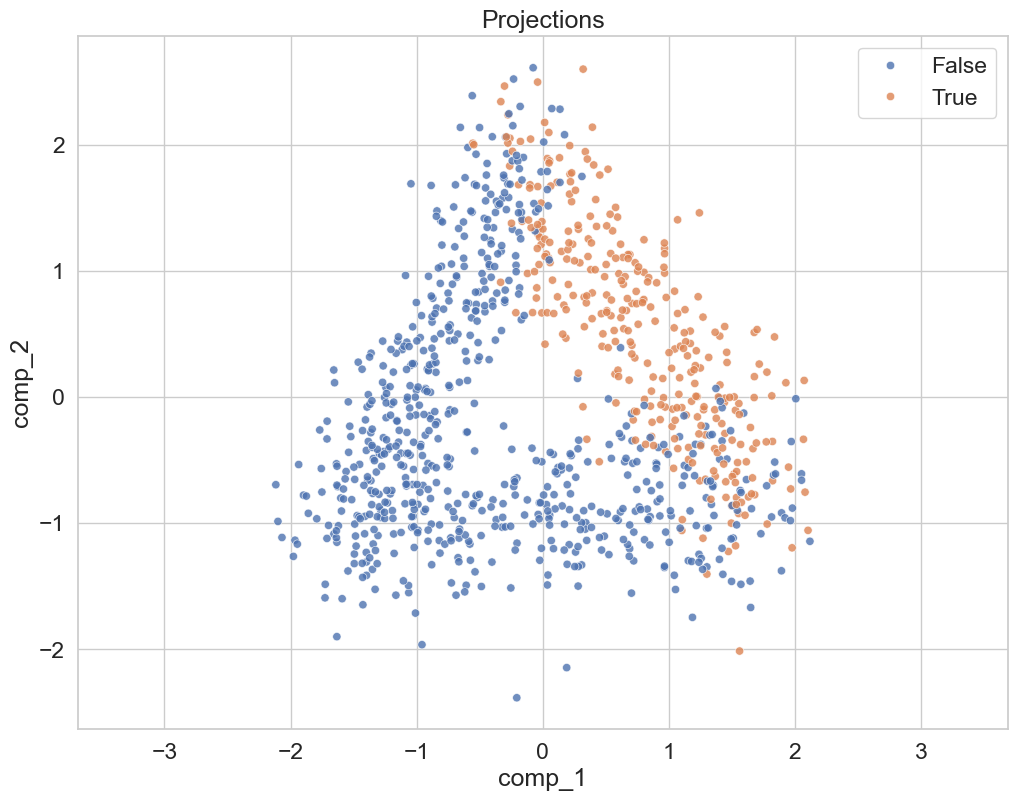

In [542]:
X_reduced_df = pd.DataFrame(X_reduced, columns=['comp_1', 'comp_2'])#, 'comp_3'])#, 'comp_4'])
#X_reduced_df['comp_3'] = (X_reduced_df['comp_2']+X_reduced_df['comp_1']-X_scaled_['feat_6']-X_scaled_['feat_15'])/4
#X_reduced_df['comp_4'] = (X_reduced_df['comp_2']+X_reduced_df['comp_1']+X_scaled_['feat_7']+X_scaled_['feat_10']+X_reduced_df['comp_3'])/6
X_reduced_df = X_reduced_df.join(pd.DataFrame(Ytrain, columns=['target']))

sns.scatterplot(X_reduced_df, x='comp_1', y='comp_2', hue='target', alpha=0.8)

plt.grid(True)
plt.axis('equal')
plt.legend(loc='best')
plt.title('Projections')
plt.show()

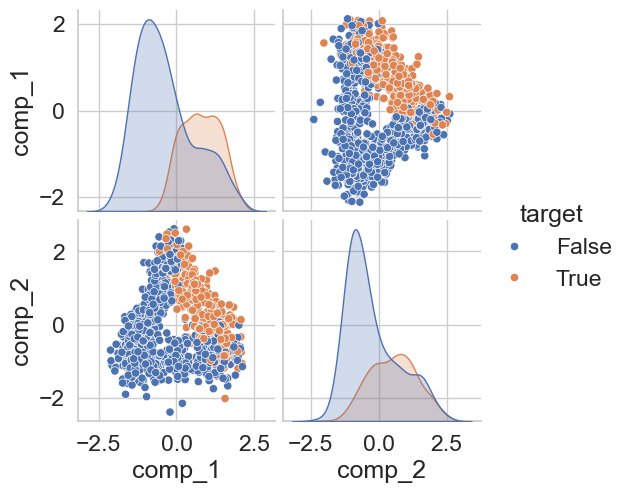

In [23]:
sns.pairplot(X_reduced_df, hue='target')
plt.show()

In [24]:
X_r = X_reduced_df.drop('target', axis=1)
clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=50, random_state=42)

random_forest = clf.fit(X_r, Ytrain)
accuracy = random_forest.score(X_r, Ytrain)
print("Accuracy of RF is: {}".format(accuracy))

relevance = random_forest.feature_importances_  

feature_names = X_r.columns

# Create a DataFrame to store feature importances with names
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': relevance
})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df

Accuracy of RF is: 0.969


,Feature,Importance
0,comp_1,0.613737
1,comp_2,0.386263


In [25]:
X_r.corr()

,comp_1,comp_2
comp_1,1.000000e+00,-9.409577e-17
comp_2,-9.409577e-17,1.000000e+00


In [26]:
X_reduced_df['comp_1'].mean()

1.0658141036401503e-17

In [27]:
X_above = X_reduced_df[X_reduced_df['comp_1'] < -1*X_reduced_df['comp_2']]
X_below = X_reduced_df [X_reduced_df ['comp_1'] >= -1*X_reduced_df ['comp_2']]

In [28]:
X_aboveY= X_above[['target']]
X_above=X_above.drop('target', axis=1)
X_belowY= X_below[['target']]
X_below=X_below.drop('target', axis=1)
print()

In [236]:
X_below

,comp_1,comp_2
4,0.662553,-0.228139
6,-0.240977,1.332466
7,-0.007486,0.668677
9,-0.541386,1.688483
10,1.814518,-0.949373
...,...,...
995,0.132809,1.898982
996,-0.207748,1.917996
997,0.601103,0.164244
998,0.518534,0.392762


In [237]:
X_above

,comp_1,comp_2
0,-0.907275,0.214763
1,-0.966867,-0.375537
2,0.113835,-0.606766
3,-1.626382,-0.708800
5,0.829072,-0.886825
...,...,...
981,0.041118,-1.409963
984,-1.182412,-0.038702
985,-1.313383,-1.319526
988,-0.665426,-1.304843


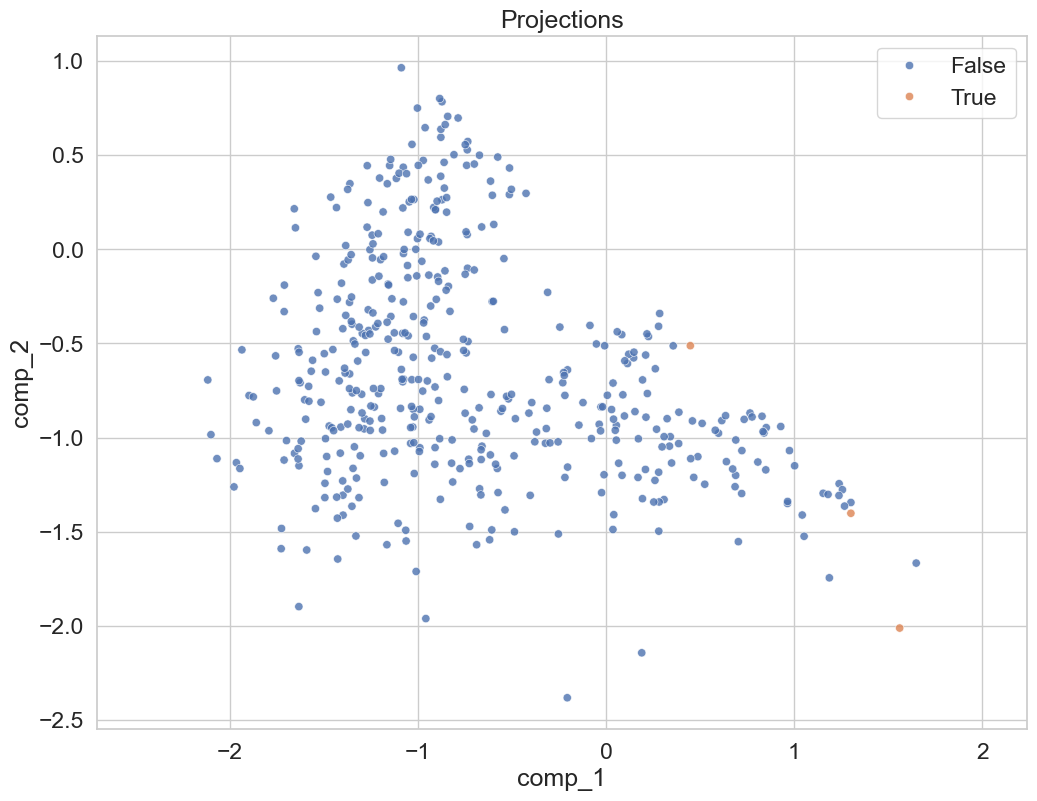

In [244]:
sns.scatterplot(X_above.join(X_aboveY), x='comp_1', y='comp_2', hue='target', alpha=0.8)

plt.grid(True)
plt.axis('equal')
plt.legend(loc='best')
plt.title('Projections')
plt.show()

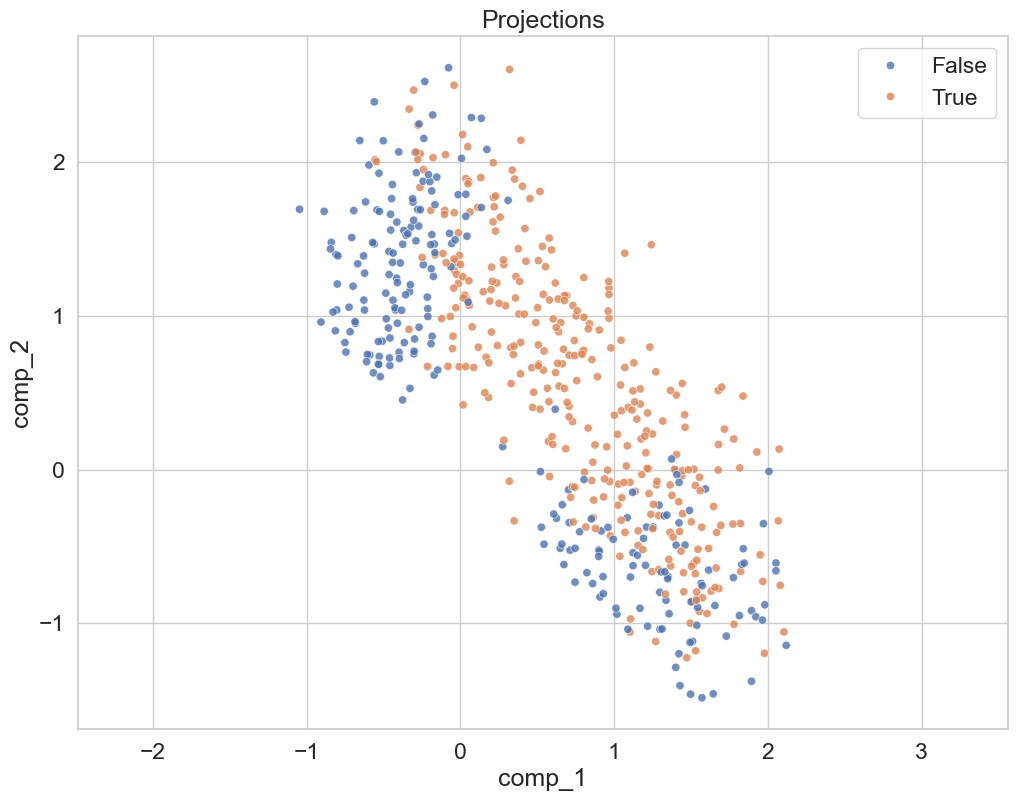

In [200]:
sns.scatterplot(X_below.join(X_belowY), x='comp_1', y='comp_2', hue='target', alpha=0.8)

plt.grid(True)
plt.axis('equal')
plt.legend(loc='best')
plt.title('Projections')
plt.show()

In [201]:
X_below_1 = X_below.join(X_belowY)[X_below['comp_1'] < X_below['comp_2']]
X_below_2 = X_below.join(X_belowY)[X_below['comp_1'] >= X_below['comp_2']]

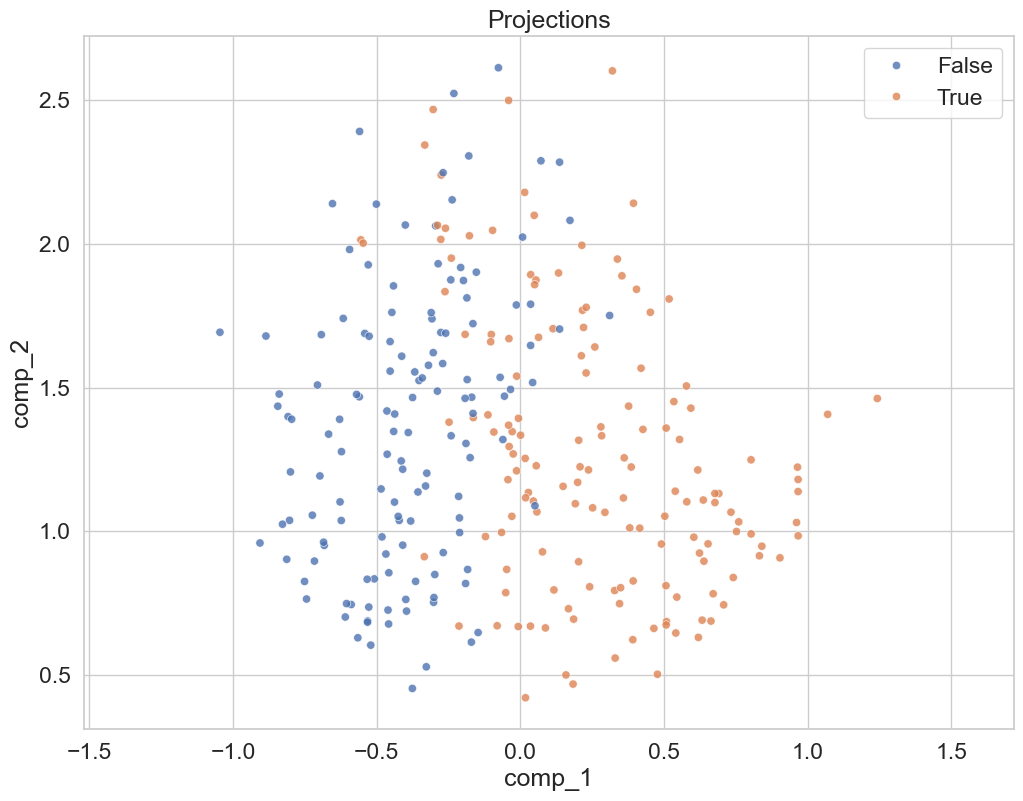

In [202]:
sns.scatterplot(X_below_1, x='comp_1', y='comp_2', hue='target', alpha=0.8)

plt.grid(True)
plt.axis('equal')
plt.legend(loc='best')
plt.title('Projections')
plt.show()

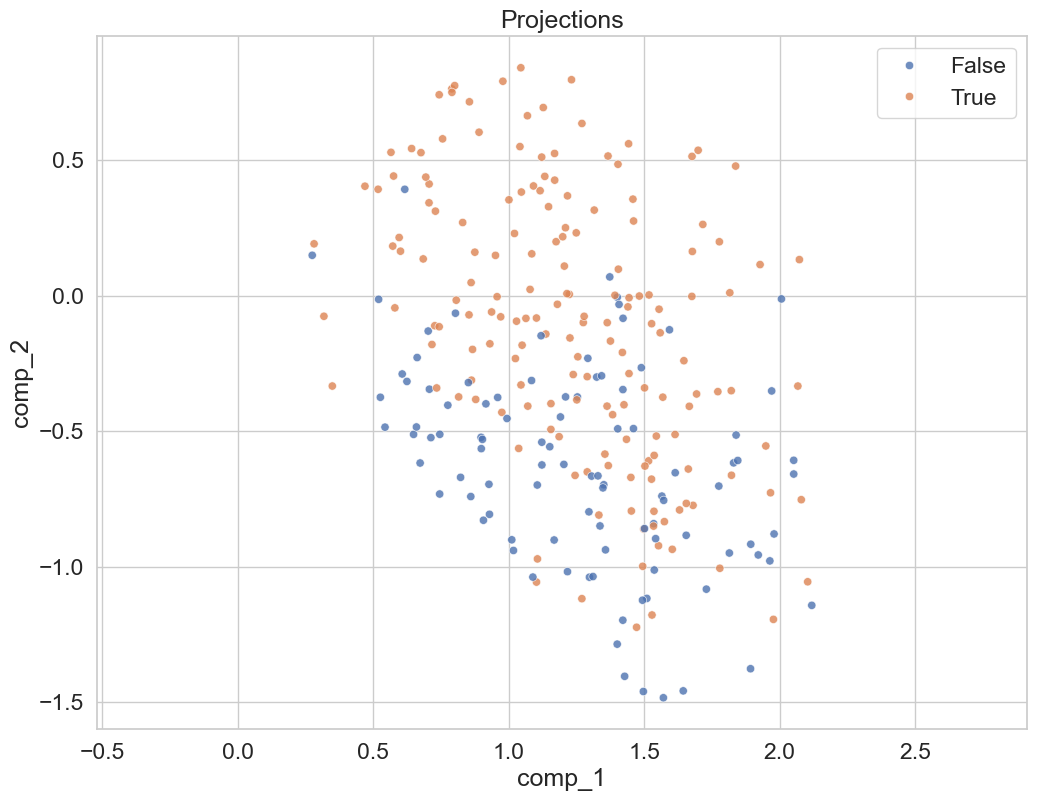

In [203]:
sns.scatterplot(X_below_2, x='comp_1', y='comp_2', hue='target', alpha=0.8)

plt.grid(True)
plt.axis('equal')
plt.legend(loc='best')
plt.title('Projections')
plt.show()

In [204]:
X_below_1Y= X_below_1[['target']]
X_below_1=X_below_1.drop('target', axis=1)
X_below_2Y= X_below_2[['target']]
X_below_2=X_below_2.drop('target', axis=1)
print(X_below_2.shape)

(266, 2)


---
### SVM's for below clusters
---

In [171]:
v_C = [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6]
v_g =  [0.0001, 0.001, 0.009, 0.01, 0.011, 0.012, 0.013, 0.1, 1, 2] # np.arange(0.009, 0.01, 0.0001) [0.0001, 0.001, 0.009, 0.01, 0.011, 0.1, 1, 2]
params_dir = {'linear':{
           'C': v_C, 'gamma':v_g},
          'rbf':{'C': v_C,
          'gamma':v_g}}

kernel = 'rbf'
svc = GridSearchCV(SVC(kernel=kernel), 
                    params_dir[kernel],
                    n_jobs=-1,
                    cv=10).fit(X_below_1, X_below_1Y.values.flatten())

print(svc.score(X_below_1, X_below_1Y.values.flatten()))
print(svc.best_params_)
print(svc.best_estimator_)
print(svc.best_score_)

0.8763250883392226
{'C': 2, 'gamma': 0.1}
SVC(C=2, gamma=0.1)
0.8726600985221674


In [451]:
svc_below1 = SVC(kernel='rbf', C=10, gamma=0.1)
svc_below1.fit(X_below_1, X_below_1Y.values.flatten())
svc_below1.score(X_below_1, X_below_1Y.values.flatten())

0.872791519434629

In [452]:
v_C = [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9]
v_g = [1e-6, 1e-5,0.0001, 0.001, 0.01, 0.09, 0.1, 0.11, 1, 2]
params_dir = {'linear':{
           'C': v_C, 'gamma':v_g},
          'rbf':{'C': v_C,
          'gamma':v_g}}

kernel = 'linear'
svc = GridSearchCV(SVC(kernel=kernel), 
                    params_dir[kernel],
                    n_jobs=-1,
                    cv=10).fit(X_below_2, X_below_2Y.values.flatten())

print(svc.score(X_below_2, X_below_2Y.values.flatten()))
print(svc.best_params_)
print(svc.best_score_)
print(svc.best_estimator_)

0.7518796992481203
{'C': 1, 'gamma': 1e-06}
0.755982905982906
SVC(C=1, gamma=1e-06, kernel='linear')


In [455]:
svc_below2 = SVC(kernel='linear', C=1, gamma=1)
svc_below2.fit(X_below_2, X_below_2Y.values.flatten())
svc_below2.score(X_below_2, X_below_2Y.values.flatten())

0.7518796992481203

---
### Training and Validation 
---

In [538]:
Xt, Xval_, Yt, Yval_ = train_test_split(X_reduced, Ytrain, test_size=0.2, random_state=1414210796)

---
### Produce Results on Test set
---

In [539]:
Xtest_scaled_ = pd.DataFrame(alpha_scaler.transform(Xtest), columns=Xtest.columns)
Xtest_cleaned_ = Xtest_scaled_[np.array(Xtrain_cleaned.columns)]
Xtest_reduced_ = pca_.transform(Xtest_cleaned_)

Xtest_reduced_ = scaler_pca.transform(Xtest_reduced_)
Xtest_reduced_df = pd.DataFrame(Xtest_reduced_, columns=['comp_1', 'comp_2'])

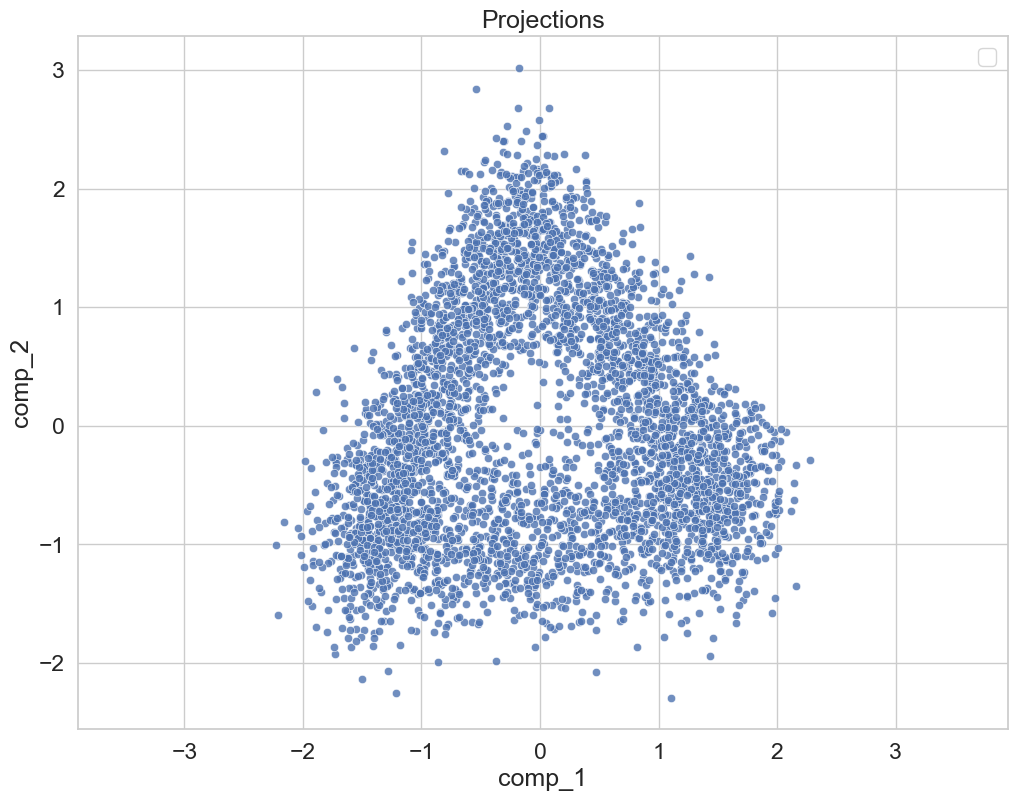

In [527]:
sns.scatterplot(Xtest_reduced_df, x='comp_1', y='comp_2', alpha=0.8)

plt.grid(True)
plt.axis('equal')
plt.legend(loc='best')
plt.title('Projections')
plt.show()

In [528]:
Xabove_idx = np.argwhere(Xtest_reduced_[:,0] < -1*Xtest_reduced_[:,1]).flatten()
Xbelow_idx = np.argwhere(Xtest_reduced_[:,0] >= -1*Xtest_reduced_[:,1]).flatten()
Xtest_above = Xtest_reduced_df[Xtest_reduced_df['comp_1'] < -1*Xtest_reduced_df['comp_2']]
Xtest_below = Xtest_reduced_df[Xtest_reduced_df['comp_1'] >= -1*Xtest_reduced_df ['comp_2']]

Xbelow1_idx = np.argwhere(Xtest_below.values[:,0] < Xtest_below.values[:,1]).flatten()
Xbelow2_idx = np.argwhere(Xtest_below.values[:,0] >= Xtest_below.values[:,1]).flatten()

Xtest_below1 = Xtest_below[Xtest_below['comp_1'] < Xtest_below['comp_2']]
Xtest_below2 = Xtest_below[Xtest_below['comp_1'] >= Xtest_below['comp_2']]

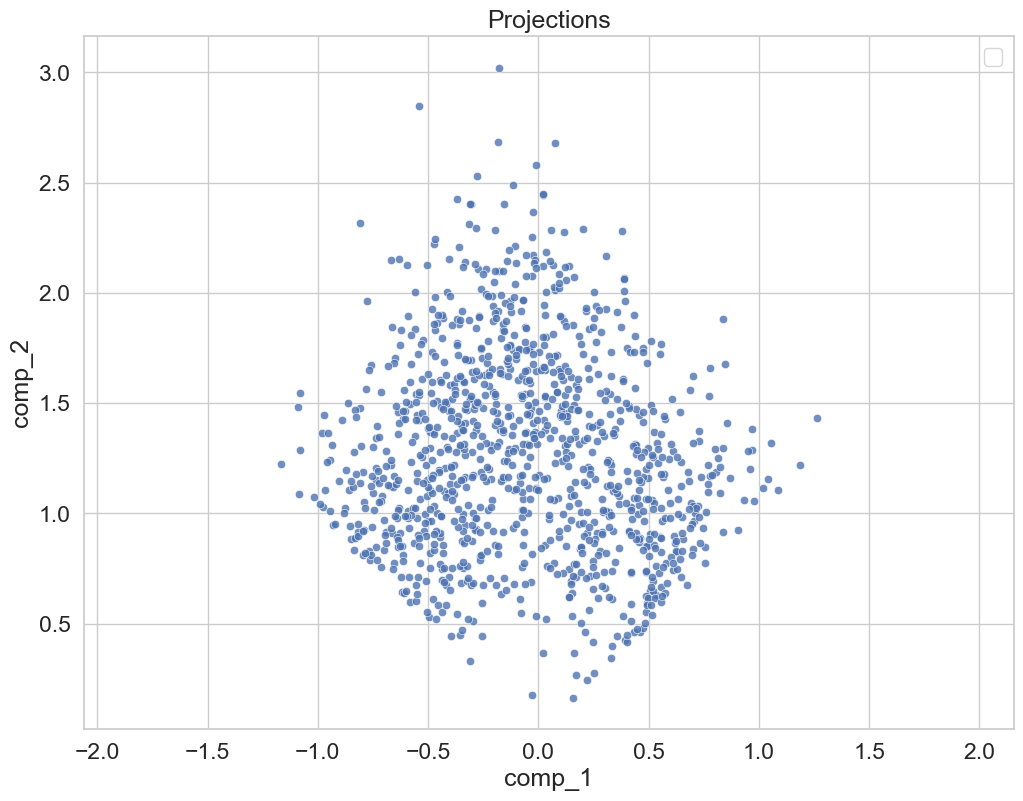

In [529]:
sns.scatterplot(Xtest_below1, x='comp_1', y='comp_2', alpha=0.8)

plt.grid(True)
plt.axis('equal')
plt.legend(loc='best')
plt.title('Projections')
plt.show()

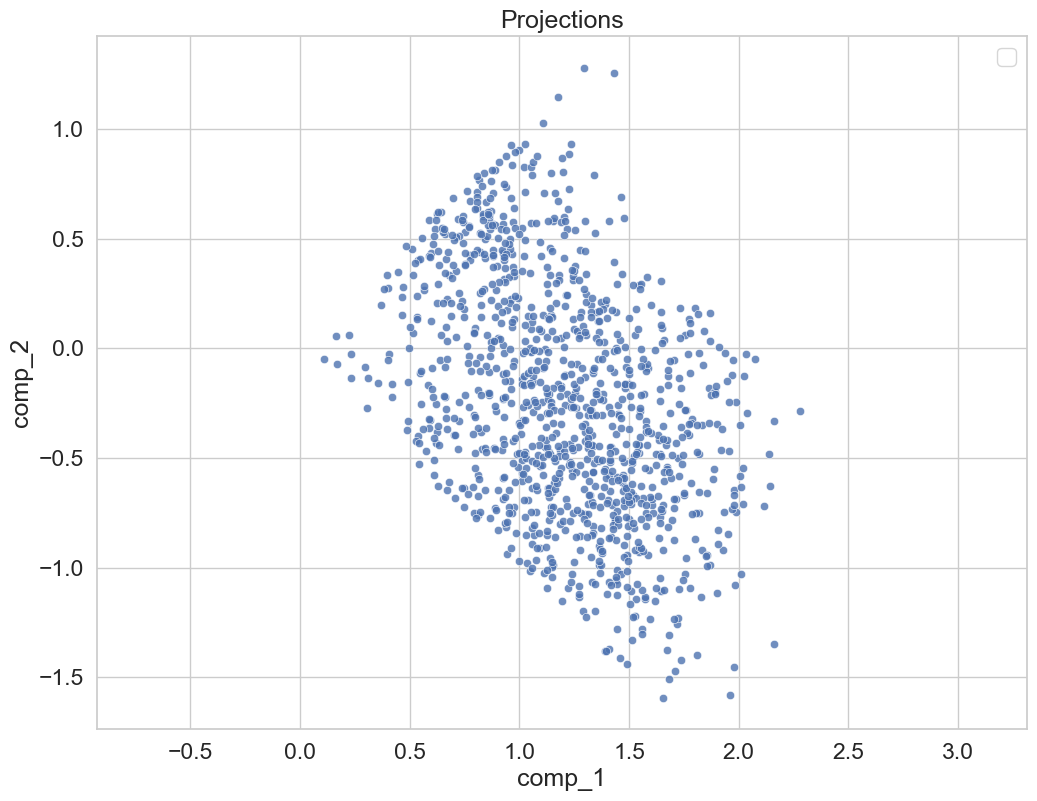

In [530]:
sns.scatterplot(Xtest_below2, x='comp_1', y='comp_2', alpha=0.8)

plt.grid(True)
plt.axis('equal')
plt.legend(loc='best')
plt.title('Projections')
plt.show()

In [531]:
above_preds = np.zeros(len(Xabove_idx)).astype(bool)#svc_above.predict(Xtest_above)
below1_preds = svc_below1.predict(Xtest_below1)
below2_preds = svc_below2.predict(Xtest_below2)


In [532]:
Xbelow_preds = np.zeros(len(Xtest_below))
Xbelow_preds[Xbelow1_idx] = below1_preds
Xbelow_preds[Xbelow2_idx] = below2_preds

In [533]:
Xtest_preds = np.zeros(len(Xtest_scaled_))
#Xtest_preds = svc_below.predict(Xtest_reduced_)

In [534]:
Xtest_preds[Xabove_idx] = above_preds
Xtest_preds[Xbelow_idx] = Xbelow_preds


In [535]:
Xtest_reduced_df['target'] = Xtest_preds.astype(bool)

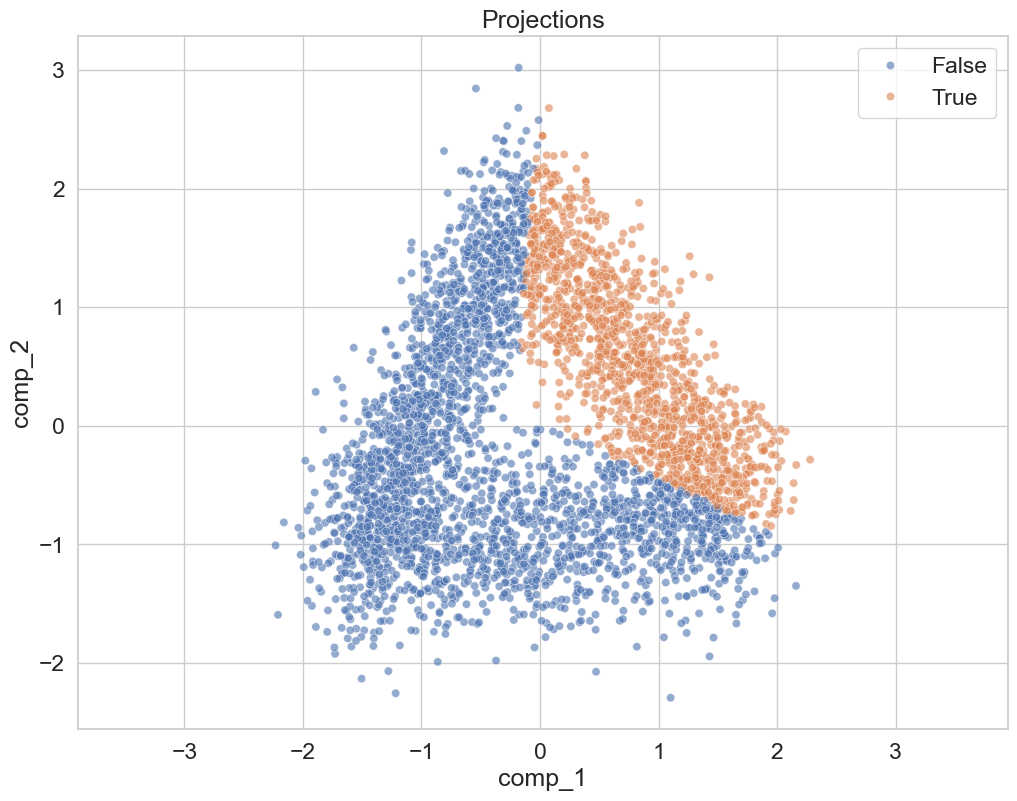

In [536]:
sns.scatterplot(Xtest_reduced_df, x='comp_1', y='comp_2', hue='target', alpha=0.6)

plt.grid(True)
plt.axis('equal')
plt.legend(loc='best')
plt.title('Projections')
plt.show()

In [537]:
np.sum(Xtest_preds)

1339.0

In [450]:
from datetime import datetime
from IPython.display import display, HTML

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "ID": test_data['ID'], 
    "target": Xtest_preds,
}, columns=['ID', 'target'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))

Created a CSV file: submission_20241220_144457.csv.
